# Imports

In [1]:
import os
import json
import paths
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights

## Setting model parameters

In [2]:
parameters = {
    'lr': 0.001,
    'batch_size': 64,
    'epochs': 10,
    'num_workers': 6
}

## Use GPU for training if available

In [3]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

### Apply necessary transformations for resnet18 model. We are working with a pre-trained model, so we have to apply the same transformations that were applied during the pre-training phase which are:

<ul>
<li>
Converting the grayscale image to RGB
</li>
<li>
Resize the image to (244, 244)
</li>
<li>
Normalize the images using the mean and std that was used in pre-training
</li>
</ul>

In [4]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.Resize(256),
    transforms.CenterCrop(224),           # Resize to fit ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ResNet
])

### Loading the datasets from training and testing folders inside  **/model_inputs_outputs/inputs**

In [5]:
# Load the datasets
train_dataset = datasets.ImageFolder(root=paths.TRAIN_DIR, transform=transform)
test_dataset = datasets.ImageFolder(root=paths.TEST_DIR, transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=parameters['batch_size'], shuffle=True, num_workers=parameters['num_workers'], persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=parameters['batch_size'], shuffle=False, num_workers=parameters['num_workers'], persistent_workers=True)

### We are storing the class names. This is important to adjust the last layer in the ResNet model.<br> The layer should have a dimension of (num_features, num_classes)

In [6]:
class_names = sorted(os.listdir(paths.TRAIN_DIR))
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [7]:
num_classes = len(class_names)

# Load a pre-trained ResNet model
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features

# Modify the final fully connected layer to match the number of classes (10 for MNIST)
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

### Since this is a multiclass classification problem, cross entropy loss is a good choice. We choose Adam optimizer, it is one of the most used optimizers in deep learning.<br> Feel free to try other choices like NllLoss (negative log likelihood loss) or SGD optimizer.

In [8]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=parameters['lr'])

## Training loop

In [9]:
# Training the model
print('Starting training...')
loss_per_epoch = []
num_epochs = parameters['epochs']
progress_bar = tqdm(range(num_epochs), desc='Total Epochs')
for epoch in progress_bar:
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, leave=True, desc='Epoch progress'):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    progress_bar.set_postfix({'Loss': epoch_loss})
    loss_per_epoch.append(epoch_loss)


Starting training...


Total Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/94 [00:00<?, ?it/s]

## Loss plot

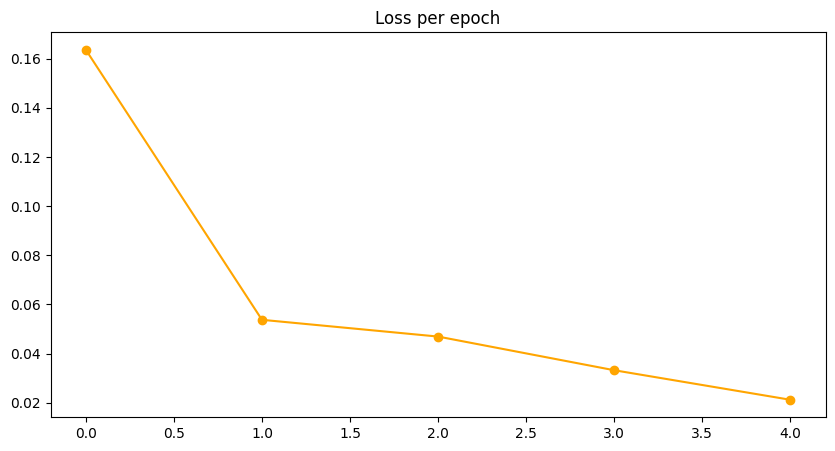

In [10]:
plt.figure(figsize=(10, 5))
plt.title('Loss per epoch')
plt.plot(loss_per_epoch, marker='o', color='orange')
plt.show()

## Save the model

In [11]:
torch.save(model, paths.MODEL_PATH)

with open(paths.MODEL_PARAMS_PATH, 'w') as f:
    json.dump(parameters, f)